Tutorial de proyecto NLP

      Objetivo: Implementar un sistema que sea capaz de detectar automáticamente si una página web contiene spam o no basándonos en su URL.

In [1]:
!pip install missingno lazypredict
!pip install unidecode
!pip install nltk
!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [55]:
import pandas as pd
import nltk
import regex as re
from nltk.corpus import stopwords
from unidecode import unidecode
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import numpy as np
from sklearn.model_selection import GridSearchCV
import joblib


In [3]:
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

1. Cargar el conjunto de datos.

In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv')
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


2. Preprocesa los enlaces.

In [5]:
df = df[['is_spam','url']]

In [6]:
# Analizo si hay duplicados.
df.duplicated().sum()

np.int64(630)

Hay 630 observaciones duplicadas.

In [7]:
# Elimino los duplicados.
df.drop_duplicates(inplace=True, ignore_index=True)

In [8]:
# Compruebo que he eliminado correctamente los duplicados.
df.duplicated().sum()

np.int64(0)

In [9]:
# Codifico la variable is_spam.
df['is_spam'] = df['is_spam'].astype(int)
df.head()

,is_spam,url
0,1,https://briefingday.us8.list-manage.com/unsubs...
1,1,https://www.hvper.com/
2,1,https://briefingday.com/m/v4n3i4f3
3,0,https://briefingday.com/n/20200618/m#commentform
4,1,https://briefingday.com/fan


In [10]:
# Distribución de la variable is_spam.
df.is_spam.value_counts()

is_spam
0    2125
1     244
Name: count, dtype: int64

Hay 2125 url que no contiene spam y 244 que sí los contiene.

In [11]:
# Balanceo a la baja la muestra. Es decir, me quedo con 244 observaciones en cada caso.
frecuencia_minima = df['is_spam'].value_counts().min()

# Crear una muestra ponderada según la frecuencia de la clase minoritaria
df_adjusted = df.groupby('is_spam').apply(lambda x: x.sample(frac=frecuencia_minima / len(x))).reset_index(drop=True)
df_adjusted.head()

/tmp/ipykernel_615/3064425889.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_adjusted = df.groupby('is_spam').apply(lambda x: x.sample(frac=frecuencia_minima / len(x))).reset_index(drop=True)


,is_spam,url
0,0,https://www.adweek.com/digital/facebook-gaming...
1,0,https://www.texastribune.org/2019/07/22/asylum...
2,0,https://www.reuters.com/article/us-hongkong-pr...
3,0,https://www.reuters.com/article/us-unilever-wh...
4,0,https://www.cnn.com/2020/06/30/politics/kentuc...


In [12]:
df_adjusted.is_spam.value_counts()

is_spam
0    244
1    244
Name: count, dtype: int64

In [13]:
df_adjusted.isna().sum()

is_spam    0
url        0
dtype: int64

No hay valores nulos

In [14]:
def preprocess_url(text):
  # Eliminar 'http', 'https', 'www', 'com', 'html' de la URL
  text = re.sub(r'https?://(www\.)?', '', text)  
  text = re.sub(r'\.com|\.html', '', text)  
  # Pasar el texto a minúscula
  text = text.lower()
  # Eliminar cualquier carácter que no sea una letra (a-z) o un espacio en blanco ( )
  text = re.sub(r'[^a-z ]', " ", text)
  # Solo texto
  text = re.sub(r'[^\w\s]|[\d]', '', text)
  # Eliminación de los espacios adicionales
  text = re.sub(r'\s+', ' ', text).strip()
  # Remove tags
  text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)
  # Tokenizamos
  tokens = text.split(' ')
  # Almacenamos las palabras que no son stopwords
  ls_stopwords = stopwords.words('spanish')
  tokens = [unidecode(token) for token in tokens if token not in ls_stopwords]
  # Lematizamos los tokens
  lemmatizer = WordNetLemmatizer()
  tokens = [lemmatizer.lemmatize(token) for token in tokens if len(token)>2]
  return ' '.join(tokens)


In [15]:
# Aplicar la función a la columna 'url'
df['url_prepro'] = df['url'].apply(preprocess_url)

# Guardar el DataFrame ajustado
df_adjusted = df.copy()

# Mostrar algunos valores para confirmar
print(df_adjusted[['url', 'url_prepro']].head())

                                                 url  \
0  https://briefingday.us8.list-manage.com/unsubs...   
1                             https://www.hvper.com/   
2                 https://briefingday.com/m/v4n3i4f3   
3   https://briefingday.com/n/20200618/m#commentform   
4                        https://briefingday.com/fan   

                            url_prepro  
0  briefingday list manage unsubscribe  
1                                hvper  
2                          briefingday  
3              briefingday commentform  
4                      briefingday fan  


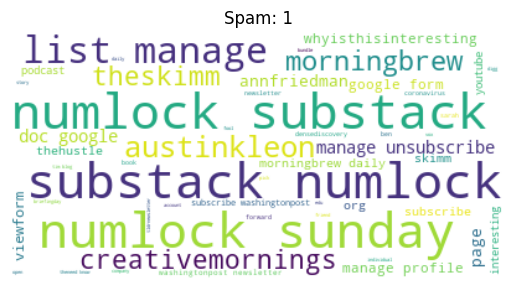

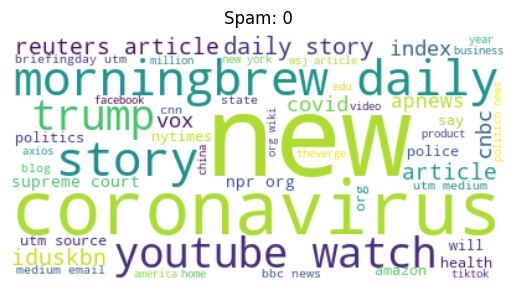

In [16]:
# Obtengo los valores únicos de la columna is_spam.
spam = df_adjusted.is_spam.unique()

# Creo un gráfico de nubes de palabras para cada valor de spam.
for spams in spam:
    textos_spam = ' '.join(df_adjusted[df_adjusted.is_spam == spams]['url_prepro'].tolist())
    wordcloud = WordCloud(background_color='white', max_words=50).generate(textos_spam)
    plt.title(f"Spam: {spams}")
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Eliminar los ejes
    plt.show()


In [19]:
# Divido el conjunto de datos.
X_train, X_test, y_train, y_test = train_test_split(df.url_prepro, df.is_spam, test_size=0.2, random_state=42)

In [23]:
le = LabelEncoder()

y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

In [25]:
vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)
X_train_num = vectorizer.fit_transform(X_train)
X_test_num = vectorizer.transform(X_test)


In [26]:
X_train_num

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7609 stored elements and shape (1895, 523)>

In [27]:
vectorizer.get_feature_names_out()

array(['abcnews', 'abortion', 'about', 'account', 'action', 'activist',
       'ad', 'administration', 'advertising', 'adweek', 'afghanistan',
       'after', 'air', 'album', 'all', 'amazon', 'america', 'american',
       'amid', 'and', 'animal', 'annfriedman', 'announces', 'anthony',
       'apnews', 'app', 'apple', 'archive', 'are', 'art', 'article',
       'asia', 'austinkleon', 'autonomous', 'award', 'axios', 'baby',
       'back', 'ban', 'bar', 'battle', 'bbc', 'begin', 'being', 'ben',
       'berman', 'best', 'biden', 'big', 'bigspaceship', 'bill',
       'billion', 'black', 'blog', 'boeing', 'book', 'bounty', 'boycott',
       'brand', 'brew', 'briefingday', 'broadway', 'brook', 'brunch',
       'bubba', 'business', 'businessinsider', 'but', 'buy', 'buyback',
       'buzzfeednews', 'california', 'call', 'cam', 'campaign', 'can',
       'canada', 'cant', 'car', 'care', 'case', 'category', 'cbsnews',
       'center', 'ceo', 'change', 'channel', 'charles', 'check',
       'cheddar'

3. Construir un SVM.

In [33]:
model = SVC(kernel = "linear", random_state = 42)
model.fit(X_train_num, y_train)

SVC(kernel='linear', random_state=42)

In [35]:
y_pred = model.predict(X_test_num)
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

In [42]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       435
           1       0.92      0.56      0.70        39

    accuracy                           0.96       474
   macro avg       0.94      0.78      0.84       474
weighted avg       0.96      0.96      0.96       474



El modelo es muy bueno prediciendo la clase mayoritaria (clase 0) pero tiene problemas para predecir correctamente la clase minoritaria (clase 1), lo que se refleja en el bajo recall (56%) y el F1-score (0.70) de la clase 1.

Asimismo, aunque el valor de accuracy es alto, el bajo rendimiento para la clase 1 sugiere que el modelo tiene dificultades con las clases desbalanceadas.

4. Optimizar el modelo anterior.

In [43]:
hyperparams = {
    "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    "kernel": ["linear", "poly", "rbf", "sigmoid", "precomputed’"],
    "degree": [1, 2, 3, 4, 5],
    "gamma": ["scale", "auto"]
}

grid = GridSearchCV(model, hyperparams, scoring = "accuracy", cv = 5)
grid

GridSearchCV(cv=5, estimator=SVC(kernel='linear', random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'degree': [1, 2, 3, 4, 5], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid',
                                    'precomputed’']},
             scoring='accuracy')

In [45]:
grid.fit(X_train_num, y_train)

print(f"Best hyperparameters: {grid.best_params_}")

Best hyperparameters: {'C': 1, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly'}


/home/vscode/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
350 fits failed out of a total of 1750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
350 fits failed with the following error:
Traceback (most recent call last):
  File "/home/vscode/.local/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/vscode/.local/lib/python3.10/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/home/vscode/.local/lib/python3.10/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/home/vscode/.l

Best hyperparameters: {'C': 1, 'degree': 1, 'gamma': 'scale', 'kernel': 'poly'}

In [49]:
opt_model = SVC(C = 1, degree = 1, gamma = "scale", kernel = "poly", random_state = 42)
opt_model.fit(X_train_num, y_train)
y_pred = opt_model.predict(X_test_num)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       435
           1       0.92      0.56      0.70        39

    accuracy                           0.96       474
   macro avg       0.94      0.78      0.84       474
weighted avg       0.96      0.96      0.96       474



Tras optimizar el modelo se obtienen los mismos resultados.

5. Guardar el modelo.

In [54]:
carpeta_modelos = '/workspaces/Proyecto25_albaebauluz/models'
modelo_op = f'{carpeta_modelos}/opt_model.pkl'
joblib.dump(opt_model, modelo_op)

print(f"Modelo guardado en {carpeta_modelos}")


Modelo guardado en /workspaces/Proyecto25_albaebauluz/models
